**Description:** This code implements a Deep Q-Network (DQN) by utilizing the enn_model.h5 as the environment and performing optimal actions accordingly. A valid path to the enn_model.h5 must be provided. The output corresponds to 200 episodes, and a summary of the performance is generated. Subsequent code scripts plot various metrics.

In [4]:
# === Load Libraries ===
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
import time
import os
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# Suppress TensorFlow informational messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# === Load Trained ENN Model ===
enn_model_path = "/Users/administrator/Desktop/All desktop-data/Prof-Irshad Papers/2025-Papers/10K-Paper/Crop-IoT-Paper/IoT-Journal-Submission/Manuscript-R2/Code-For-Github/enn_model.h5"
try:
    enn_model = load_model(enn_model_path)
    print("ENN model loaded successfully from:", enn_model_path)
except (IOError, ImportError) as e:
    print(f"Error loading ENN model: {e}")
    print("Using a dummy ENN model for demonstration purposes.")
    enn_model = Sequential([Dense(1, input_shape=(1, 8), activation='sigmoid')])
    enn_model.compile(loss='binary_crossentropy', optimizer='adam')

# === Define Environment Parameters ===
state_keys = ['N', 'P', 'K', 'Temp', 'H', 'pH', 'R', 'WL']
state_size = len(state_keys)
actions = [
    "Do Nothing", "Irrigate", "Fertilize", "Ventilate",
    "Irrigate + Fertilize", "Irrigate + Ventilate",
    "Fertilize + Pesticide", "Pesticide / Fungicide",
    "Request Manual Check"
]
n_actions = len(actions)

# === REVISED Environment for More Effective Learning ===
class SimulatedGreenhouseEnv:
    def __init__(self, scaler, enn_model):
        self.state_size = state_size
        self.scaler = scaler
        self.enn_model = enn_model
        self.ideal_state = np.full(self.state_size, 0.7)
        self._raw_state = None
        self.consecutive_good_steps = 0
        self.reset()

    def reset(self):
        self.consecutive_good_steps = 0
        self._raw_state = np.random.uniform(low=0.4, high=0.8, size=self.state_size)
        return self._get_normalized_state_with_ch()

    def step(self, action_idx):
        action_effects = np.zeros(self.state_size)
        if actions[action_idx] in ["Irrigate", "Irrigate + Fertilize", "Irrigate + Ventilate"]:
            action_effects[state_keys.index('WL')] = 0.15
        if actions[action_idx] in ["Fertilize", "Irrigate + Fertilize", "Fertilize + Pesticide"]:
            action_effects[state_keys.index('N')] += 0.1
            action_effects[state_keys.index('P')] += 0.1
            action_effects[state_keys.index('K')] += 0.1
        if actions[action_idx] in ["Ventilate", "Irrigate + Ventilate"]:
            action_effects[state_keys.index('Temp')] = -0.1
            action_effects[state_keys.index('H')] = -0.1

        self._raw_state += action_effects
        self._raw_state -= np.random.uniform(0.02, 0.05, size=self.state_size)
        self._raw_state = np.clip(self._raw_state, 0, 1)

        next_state_with_ch, ch_bin = self._get_normalized_state_with_ch(return_ch_bin=True)

        done = False
        if ch_bin == 1:
            reward = 20
            self.consecutive_good_steps += 1
        else:
            reward = -1
            self.consecutive_good_steps = 0

        if action_idx != 0:
            reward -= 0.5

        if self.consecutive_good_steps >= 5:
            done = True
            reward += 50

        return next_state_with_ch, reward, done, ch_bin

    def _get_normalized_state_with_ch(self, return_ch_bin=False):
        normalized_state = self.scaler.transform(self._raw_state.reshape(1, -1)).flatten()
        enn_input = normalized_state.reshape(1, 1, -1)
        ch_pred = self.enn_model.predict(enn_input, verbose=0)[0][0]
        ch_bin = int(ch_pred >= 0.5)
        state_with_ch = np.append(normalized_state, ch_bin)
        if return_ch_bin:
            return state_with_ch, ch_bin
        return state_with_ch

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_with_ch_size = state_size + 1
        self.action_size = action_size
        self.memory = deque(maxlen=10000)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.998
        self.learning_rate = 0.0001
        self.batch_size = 64
        self.model = self._create_model()
        self.target_model = self._create_model()
        self.update_target_model()

    def _create_model(self):
        model = Sequential([
            Dense(64, input_dim=self.state_with_ch_size, activation='relu'),
            Dense(64, activation='relu'),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(loss='huber', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())
        print("Target network updated.")

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.model.predict(state.reshape(1, -1), verbose=0)
        return np.argmax(q_values[0])

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        states = np.array([i[0] for i in batch])
        actions = np.array([i[1] for i in batch])
        rewards = np.array([i[2] for i in batch])
        next_states = np.array([i[3] for i in batch])
        dones = np.array([i[4] for i in batch])

        next_q_values = self.target_model.predict(next_states, verbose=0, batch_size=self.batch_size)
        targets = rewards + self.gamma * np.amax(next_q_values, axis=1) * (1 - dones)

        current_q_values = self.model.predict(states, verbose=0, batch_size=self.batch_size)
        batch_indices = np.arange(self.batch_size)
        current_q_values[batch_indices, actions] = targets

        self.model.fit(states, current_q_values, epochs=1, verbose=0, batch_size=self.batch_size)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# === Main Training Loop ===
EPISODES = 200
TIMESTEPS_PER_EPISODE = 100
TARGET_UPDATE_FREQ = 10

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(np.array([[0]*state_size, [1]*state_size]))
env = SimulatedGreenhouseEnv(scaler, enn_model)
agent = DQNAgent(state_size, n_actions)

history = {
    "rewards": [], "success_rates": [], "episode_lengths": [],
    "avg_q_values": [], "action_distributions": [], "epsilons": []
}

test_state_for_q_tracking = env.reset()

start_time = time.time()

for episode in range(EPISODES):
    state = env.reset()
    total_reward = 0
    successful_steps = 0
    action_counts = np.zeros(n_actions, dtype=int)

    for t in range(TIMESTEPS_PER_EPISODE):
        action = agent.act(state)
        action_counts[action] += 1
        next_state, reward, done, ch_bin = env.step(action)
        if ch_bin == 1:
            successful_steps += 1
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        agent.replay()
        if done:
            break

    history['rewards'].append(total_reward)
    history['success_rates'].append(successful_steps / (t + 1))
    history['episode_lengths'].append(t + 1)
    history['action_distributions'].append(action_counts / (t + 1))
    history['epsilons'].append(agent.epsilon)
    q_values = agent.model.predict(test_state_for_q_tracking.reshape(1, -1), verbose=0)[0]
    history['avg_q_values'].append(np.mean(q_values))

    if (episode + 1) % TARGET_UPDATE_FREQ == 0:
        agent.update_target_model()

    print(f"E {episode+1}/{EPISODES} | Len: {t+1} | R: {total_reward:.2f} | Success: {history['success_rates'][-1]:.2%} | Epsilon: {agent.epsilon:.3f}")

end_time = time.time()
print(f"\nTraining finished in {end_time - start_time:.2f} seconds.")

# Calculate summary metrics
total_episodes = len(history['rewards'])
total_successful_episodes = sum(1 for rate in history['success_rates'] if rate == 1.0)
average_reward = np.mean(history['rewards'])
average_success_rate = np.mean(history['success_rates'])
average_episode_length = np.mean(history['episode_lengths'])
average_epsilon = np.mean(history['epsilons'])
average_q_value = np.mean(history['avg_q_values'])




ENN model loaded successfully from: /Users/administrator/Desktop/All desktop-data/Prof-Irshad Papers/2025-Papers/10K-Paper/Crop-IoT-Paper/IoT-Journal-Submission/Manuscript-R2/Code-For-Github/enn_model.h5
Target network updated.
E 1/200 | Len: 10 | R: 140.00 | Success: 50.00% | Epsilon: 1.000
E 2/200 | Len: 100 | R: -123.00 | Success: 1.00% | Epsilon: 0.910
E 3/200 | Len: 61 | R: 65.50 | Success: 8.20% | Epsilon: 0.806
E 4/200 | Len: 17 | R: 129.50 | Success: 29.41% | Epsilon: 0.779
E 5/200 | Len: 35 | R: 102.50 | Success: 14.29% | Epsilon: 0.726
E 6/200 | Len: 15 | R: 133.00 | Success: 33.33% | Epsilon: 0.704
E 7/200 | Len: 15 | R: 133.00 | Success: 33.33% | Epsilon: 0.684
E 8/200 | Len: 18 | R: 128.50 | Success: 27.78% | Epsilon: 0.659
E 9/200 | Len: 37 | R: 145.50 | Success: 18.92% | Epsilon: 0.612
Target network updated.
E 10/200 | Len: 10 | R: 162.50 | Success: 60.00% | Epsilon: 0.600
E 11/200 | Len: 14 | R: 137.00 | Success: 35.71% | Epsilon: 0.584
E 12/200 | Len: 19 | R: 130.50 |

E 118/200 | Len: 17 | R: 129.50 | Success: 29.41% | Epsilon: 0.050
E 119/200 | Len: 20 | R: 127.00 | Success: 25.00% | Epsilon: 0.050
Target network updated.
E 120/200 | Len: 22 | R: 187.50 | Success: 36.36% | Epsilon: 0.050
E 121/200 | Len: 11 | R: 138.50 | Success: 45.45% | Epsilon: 0.050
E 122/200 | Len: 19 | R: 128.00 | Success: 26.32% | Epsilon: 0.050
E 123/200 | Len: 15 | R: 132.50 | Success: 33.33% | Epsilon: 0.050
E 124/200 | Len: 12 | R: 137.00 | Success: 41.67% | Epsilon: 0.050
E 125/200 | Len: 10 | R: 140.00 | Success: 50.00% | Epsilon: 0.050
E 126/200 | Len: 11 | R: 138.50 | Success: 45.45% | Epsilon: 0.050
E 127/200 | Len: 15 | R: 134.50 | Success: 33.33% | Epsilon: 0.050
E 128/200 | Len: 24 | R: 140.00 | Success: 25.00% | Epsilon: 0.050
E 129/200 | Len: 15 | R: 132.50 | Success: 33.33% | Epsilon: 0.050
Target network updated.
E 130/200 | Len: 17 | R: 129.50 | Success: 29.41% | Epsilon: 0.050
E 131/200 | Len: 15 | R: 132.50 | Success: 33.33% | Epsilon: 0.050
E 132/200 | Le

In [13]:
# Convert action distributions to percentages
average_action_distributions = np.mean(np.array(history['action_distributions']), axis=0) * 100

# Print summary metrics
print("\n=== Training Summary ===")
print(f"Total Successful Episodes: {total_successful_episodes} ({total_successful_episodes / total_episodes:.2%})")
print(f"Average Reward per Episode: {average_reward:.2f}")
print(f"Average Success Rate: {average_success_rate:.2%}")
print(f"Average Episode Length: {average_episode_length:.2f} steps")
print(f"Average Epsilon: {average_epsilon:.3f}")


# Print action distribution percentages
print("\nAverage Action Distribution:")
for idx, action in enumerate(actions):
    print(f"{action}: {average_action_distributions[idx]:.2f}%")


=== Training Summary ===
Total Successful Episodes: 0 (0.00%)
Average Reward per Episode: 133.08
Average Success Rate: 35.12%
Average Episode Length: 16.17 steps
Average Epsilon: 0.145

Average Action Distribution:
Do Nothing: 15.20%
Irrigate: 7.35%
Fertilize: 1.46%
Ventilate: 3.34%
Irrigate + Fertilize: 1.39%
Irrigate + Ventilate: 9.41%
Fertilize + Pesticide: 1.18%
Pesticide / Fungicide: 2.34%
Request Manual Check: 58.33%


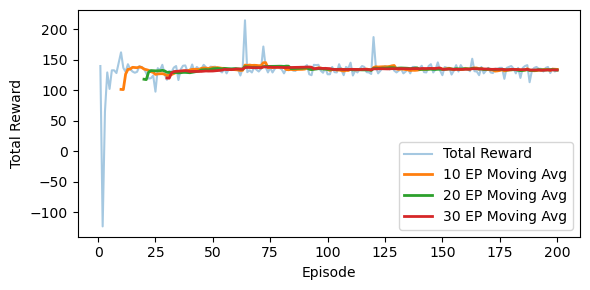

In [6]:
# Plot Rewards with different moving average

def plot_total_rewards_with_moving_averages(history):
    rewards = history['rewards']
    episodes = np.arange(1, len(rewards) + 1)

    def moving_average(data, window):
        return np.convolve(data, np.ones(window) / window, mode='valid')

    # Compute moving averages
    ma_10 = moving_average(rewards, 10)
    ma_20 = moving_average(rewards, 20)
    ma_30 = moving_average(rewards, 30)

    # Correct x-axis for each moving average
    episodes_10 = episodes[9:]
    episodes_20 = episodes[19:]
    episodes_30 = episodes[29:]

    # Plotting
    plt.figure(figsize=(6, 3))
    plt.plot(episodes, rewards, label='Total Reward', alpha=0.4)
    plt.plot(episodes_10, ma_10, label='10 EP Moving Avg', linewidth=2)
    plt.plot(episodes_20, ma_20, label='20 EP Moving Avg', linewidth=2)
    plt.plot(episodes_30, ma_30, label='30 EP Moving Avg', linewidth=2)
      # plt.title('Total Reward per Episode with Moving Averages')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.legend()
      # plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_total_rewards_with_moving_averages(history)

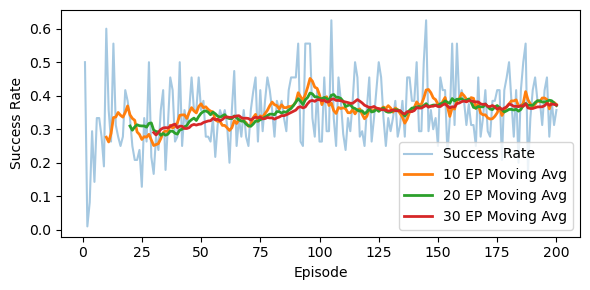

In [7]:
# Plot average success rate with different moving average
def plot_success_rate_with_moving_averages(history):
    success_rates = history['success_rates']
    episodes = np.arange(1, len(success_rates) + 1)

    def moving_average(data, window):
        return np.convolve(data, np.ones(window) / window, mode='valid')

    ma_10 = moving_average(success_rates, 10)
    ma_20 = moving_average(success_rates, 20)
    ma_30 = moving_average(success_rates, 30)

    episodes_10 = episodes[9:]
    episodes_20 = episodes[19:]
    episodes_30 = episodes[29:]

    plt.figure(figsize=(6, 3))
    plt.plot(episodes, success_rates, label='Success Rate', alpha=0.4)
    plt.plot(episodes_10, ma_10, label='10 EP Moving Avg', linewidth=2)
    plt.plot(episodes_20, ma_20, label='20 EP Moving Avg', linewidth=2)
    plt.plot(episodes_30, ma_30, label='30 EP Moving Avg', linewidth=2)
    plt.xlabel('Episode')
    plt.ylabel('Success Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_success_rate_with_moving_averages(history)

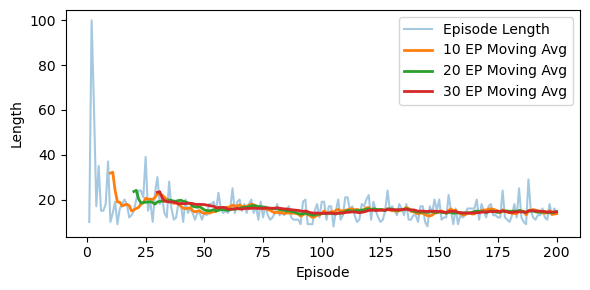

In [8]:
# Plot episode length with different moving average

def plot_episode_length_with_moving_averages(history):
    episode_lengths = history['episode_lengths']
    episodes = np.arange(1, len(episode_lengths) + 1)

    def moving_average(data, window):
        return np.convolve(data, np.ones(window) / window, mode='valid')

    ma_10 = moving_average(episode_lengths, 10)
    ma_20 = moving_average(episode_lengths, 20)
    ma_30 = moving_average(episode_lengths, 30)

    plt.figure(figsize=(6, 3))
    plt.plot(episodes, episode_lengths, label='Episode Length', alpha=0.4)
    plt.plot(episodes[9:], ma_10, label='10 EP Moving Avg', linewidth=2)
    plt.plot(episodes[19:], ma_20, label='20 EP Moving Avg', linewidth=2)
    plt.plot(episodes[29:], ma_30, label='30 EP Moving Avg', linewidth=2)
    plt.xlabel('Episode')
    plt.ylabel('Length')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Now call the function
plot_episode_length_with_moving_averages(history)


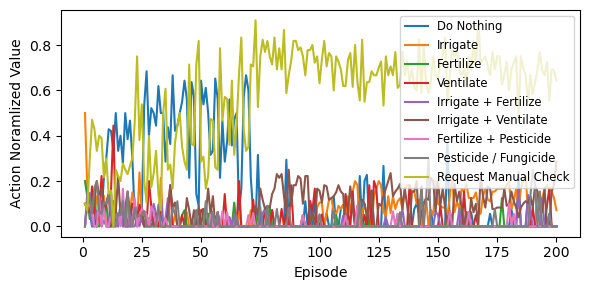

In [10]:
# Plot the different recommended actions with different moving average

def plot_action_distribution(history, actions):
    action_dist = np.array(history['action_distributions'])
    episodes = np.arange(1, action_dist.shape[0] + 1)

    plt.figure(figsize=(6, 3))
    for i in range(len(actions)):
        plt.plot(episodes, action_dist[:, i], label=actions[i])
    plt.xlabel('Episode')
    plt.ylabel('Action Noramlized Value')
    plt.legend(fontsize='small')
    plt.tight_layout()
    plt.show()

# Call the function with your list of actions
plot_action_distribution(history, actions)


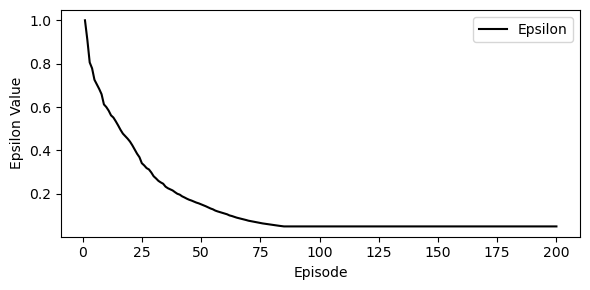

In [11]:
#Plot the behavior of the exploration rate (epsilon) over time, showing the shift from random action selection (exploration)  to exploiting the learned Q-values as the agent becomes more confident in its actions.
def plot_epsilon_decay(history):
    epsilons = history['epsilons']
    episodes = np.arange(1, len(epsilons) + 1)

    plt.figure(figsize=(6, 3))
    plt.plot(episodes, epsilons, color='black', label='Epsilon')
    plt.xlabel('Episode')
    plt.ylabel('Epsilon Value')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot epsilon decay
plot_epsilon_decay(history)
